In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

refs = [
    {'vref':3.3161, 'file':'3.31v_LUT.csv'},
    {'vref':3.2699, 'file':'3.269v_LUT.csv'},
]
index = 1
vref = refs[index]['vref']
file = refs[index]['file']
print(f'vref:{vref} file:{file}')

DAC_RESO = 4095
input_max = 5.0
volt_split_ratio = 189000.0 / (100000.0 + 189000.0)
adc_input_max = volt_split_ratio * input_max # 3.26989
def map_adc_in_from_dac_out(dac_out_value):
    # 分圧後のADC入力電圧
    voltage_in = dac_out_value * volt_split_ratio
    # print(f'{dac_out_value} -> {voltage_in}')
    # リファレンス電圧でマッピング
    adc_code = int((voltage_in / vref) * DAC_RESO)
    # 範囲制約（安全性のため）
    return max(0, min(adc_code, DAC_RESO))

adc_octaves = []
for i in [1.0, 2.0, 3.0, 4.0, 5.0]:
    adc_mapped = map_adc_in_from_dac_out(i)
    adc_octaves.append(adc_mapped)
    print(f"volt:{i} -> adc val:{adc_mapped}")

df = pd.read_csv(file, index_col=None, skiprows=1)
df2 = pd.concat([df[df['adc_code'] == i] for i in adc_octaves], ignore_index=True)

df2

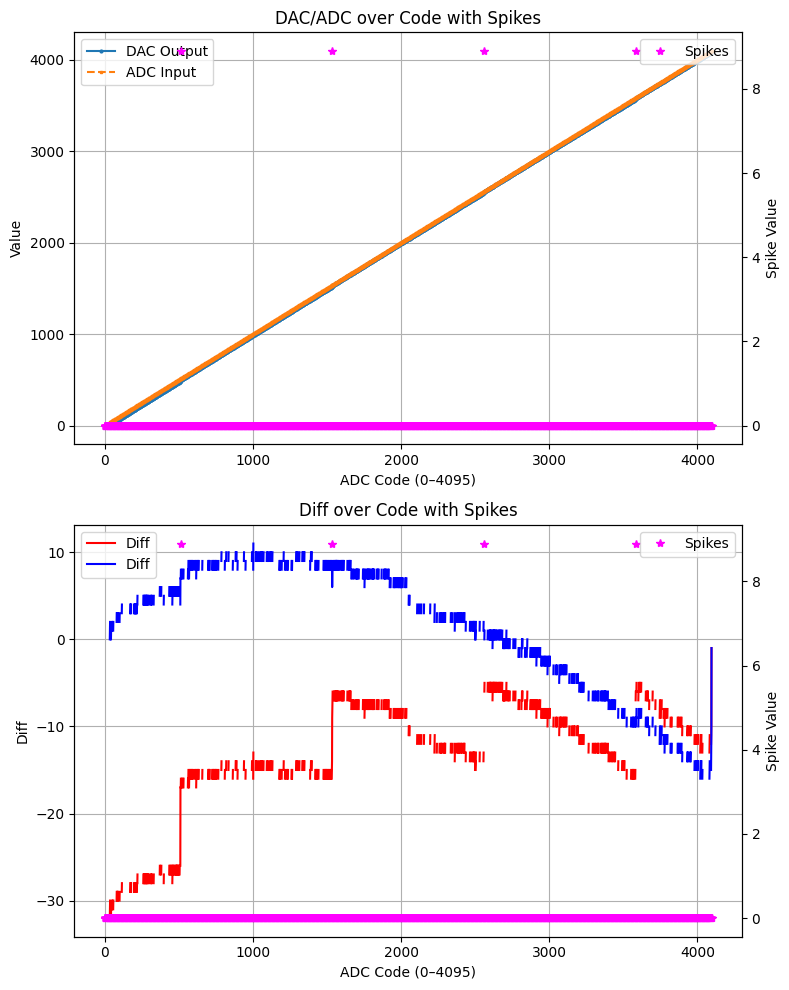

In [7]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# データ読み込み
df = pd.read_csv('3.3v_adc_raw_cor.csv', skiprows=1)

# X軸の定義（12bit範囲）
x_axis = np.arange(4096)

# 各値に対応した Y軸配列を作る
diff_mapped = np.full(4096, np.nan)  # 空配列（NaNで初期化）
cor_diff_mapped = np.full(4096, np.nan)  # 空配列（NaNで初期化）
dac_out_mapped = np.full(4096, np.nan)
adc_in_mapped = np.full(4096, np.nan)

# adc_in を X軸位置として diff 値を割り当て
for i in range(len(df)):
    adc_val = df['raw_adc'][i]
    if 0 <= adc_val < 4096:
        diff_mapped[adc_val] = df['raw_diff'][i]
        cor_diff_mapped[adc_val] = df['cor_diff'][i]
        dac_out_mapped[adc_val] = df['out'][i]
        adc_in_mapped[adc_val] = adc_val  # 同じ値になるけど整列目的

# スパイク系列の生成（同様に4096スケール）
spikes = [512, 1536, 2560, 3584]
spike_values = np.zeros(4096)
for i in spikes:
    spike_values[i] = 8.9

# グラフ描画
plt.figure(figsize=(8, 10))

# ━━ 上段 ━━ DAC/ADC系列表示 + スパイク
ax1 = plt.subplot(2, 1, 1)
ax1.plot(x_axis, dac_out_mapped, label='DAC Output', linestyle='-', marker='o', markersize=2)
ax1.plot(x_axis, adc_in_mapped, label='ADC Input', linestyle='--', marker='s', markersize=2)
ax1.set_xlabel('ADC Code (0–4095)')
ax1.set_ylabel('Value')
ax1.set_title('DAC/ADC over Code with Spikes')
ax1.grid(True)
ax1.legend(loc='upper left')

ax1_r = ax1.twinx()
ax1_r.plot(x_axis, spike_values, label='Spikes', linestyle='none', marker='*', color='magenta', markersize=6)
ax1_r.set_ylabel('Spike Value')
ax1_r.legend(loc='upper right')

# ━━ 下段 ━━ diff + スパイク
ax2 = plt.subplot(2, 1, 2)
ax2.plot(x_axis, diff_mapped, label='Diff', linestyle='-', marker='', color='red', markersize=2)
ax2.plot(x_axis, cor_diff_mapped, label='Diff', linestyle='-', marker='', color='blue', markersize=2)
ax2.set_xlabel('ADC Code (0–4095)')
ax2.set_ylabel('Diff')
ax2.set_title('Diff over Code with Spikes')
ax2.grid(True)
ax2.legend(loc='upper left')

ax2_r = ax2.twinx()
ax2_r.plot(x_axis, spike_values, label='Spikes', linestyle='none', marker='*', color='magenta', markersize=6)
ax2_r.set_ylabel('Spike Value')
ax2_r.legend(loc='upper right')

plt.tight_layout()
plt.show()

csv_data = {
    'ADC_Code': x_axis,
    'DAC_Output': dac_out_mapped,
    'ADC_Input': adc_in_mapped,
    'Diff': diff_mapped,
    'Spikes': spike_values
}

# DataFrame化
df_out = pd.DataFrame(csv_data)

# CSVとして保存（必要に応じてファイル名変更可）
df_out.to_csv('adc_graph_data.csv', index=False)
